<a href="https://colab.research.google.com/github/w4bo/AA2425-unibo-mldm/blob/master/slides/lab-06-housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The [`California Housing`](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) case study

Our task is to use California census data to forecast housing prices given the population, median income, and median housing price for each block group in California.
Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).
We will just call them "districts" for short.

## Solution of the previous `Hands on`

In [1]:
#| echo: false
#| output: false

!pip install flaml[automl]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
def preprocess(normalize=True):
    df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/housing.csv", delimiter=",")
    num_df = df.drop(columns=["ocean_proximity", "median_house_value"])
    # Filling in (i.e., impute) missing values with the median value
    num_df["total_bedrooms"] = num_df["total_bedrooms"].fillna(num_df["total_bedrooms"].median())
    # Add a new column: population_per_household = population / households
    num_df["population_per_household"] = num_df["population"] / num_df["households"]
    # Add a new column: rooms_per_household = total_rooms / households
    num_df["rooms_per_household"] = num_df["total_rooms"] / num_df["households"]
    # Add a new column: bedrooms_per_room = total_bedrooms / total_rooms
    num_df["bedrooms_per_room"] = num_df["total_bedrooms"] / num_df["total_rooms"]
    if normalize:
        # Apply standardization to all the numeric columns
        num_df = (num_df - num_df.mean()) / num_df.std()
    # One hot encode `ocean_proximity` since it is a categorical attribute
    cat_df = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')
    # Join all the dataframes
    return pd.concat([num_df, cat_df, df[["median_house_value"]]], axis=1)


df = preprocess()
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-1.327803,1.052523,0.982119,-0.804800,-0.972453,-0.974405,-0.977009,2.344709,-0.049595,0.628544,-1.029963,False,False,False,True,False,452600.0
1,-1.322812,1.043159,-0.607004,2.045841,1.357111,0.861418,1.669921,2.332181,-0.092510,0.327033,-0.888876,False,False,False,True,False,358500.0
2,-1.332794,1.038478,1.856137,-0.535733,-0.827004,-0.820757,-0.843616,1.782656,-0.025842,1.155592,-1.291654,False,False,False,True,False,352100.0
3,-1.337785,1.038478,1.856137,-0.624199,-0.719706,-0.766010,-0.733764,0.932945,-0.050328,0.156962,-0.449602,False,False,False,True,False,341300.0
4,-1.337785,1.038478,1.856137,-0.462393,-0.612408,-0.759828,-0.629142,-0.012881,-0.085614,0.344702,-0.639071,False,False,False,True,False,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.388274,-0.512579,-0.443438,-1.216099,-0.049109,-0.155020,0.165990,False,True,False,False,False,78100.0
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.922380,-0.944382,-1.008396,-0.691576,0.005021,0.276874,0.021670,False,True,False,False,False,77100.0
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.123605,-0.369528,-0.174037,-1.142566,-0.071733,-0.090316,0.021134,False,True,False,False,False,92300.0
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.304820,-0.604415,-0.393743,-1.054557,-0.091223,-0.040210,0.093464,False,True,False,False,False,84700.0


# Checking feature correlations

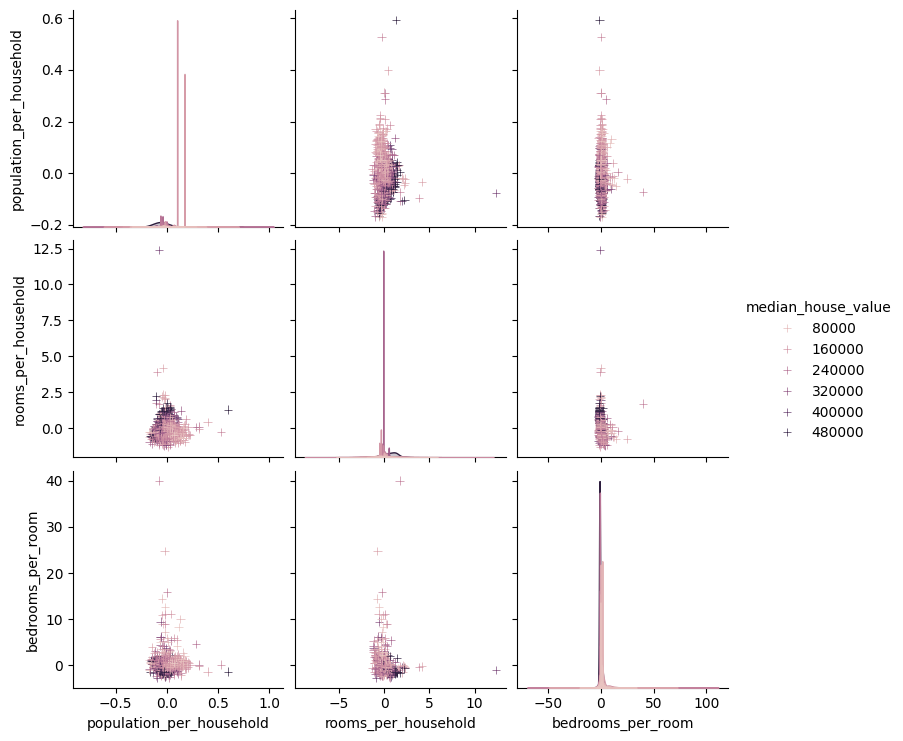

In [3]:
sns.pairplot(
    df[["population_per_household", "rooms_per_household", "bedrooms_per_room", "median_house_value"]].sample(n=1000, random_state=42),
    hue='median_house_value', markers='+'
)

# Splitting training and test data

In [4]:
from sklearn.model_selection import train_test_split
y = df["median_house_value"]  # labels
X = df.drop(columns=["median_house_value"])  # input data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (13828, 16)
X_test: (6812, 16)
y_train: (13828,)
y_test: (6812,)


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13828 entries, 5088 to 15795
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   13828 non-null  float64
 1   latitude                    13828 non-null  float64
 2   housing_median_age          13828 non-null  float64
 3   total_rooms                 13828 non-null  float64
 4   total_bedrooms              13828 non-null  float64
 5   population                  13828 non-null  float64
 6   households                  13828 non-null  float64
 7   median_income               13828 non-null  float64
 8   population_per_household    13828 non-null  float64
 9   rooms_per_household         13828 non-null  float64
 10  bedrooms_per_room           13828 non-null  float64
 11  ocean_proximity_<1H OCEAN   13828 non-null  bool   
 12  ocean_proximity_INLAND      13828 non-null  bool   
 13  ocean_proximity_ISLAND      13828

# Regression

LinearRegression fits a linear model with coefficients $w = (w_1, ..., w_p)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [6]:
from sklearn.linear_model import LinearRegression  # choose and import the model
lin_reg = LinearRegression(fit_intercept=True)  # choose model hyperparameters and initialize the model (i.e., the estimator)
lin_reg.fit(X_train, y_train)  # model fitting
lin_reg.coef_  # return the learned parameters

array([-56678.25415922, -56570.43784763,  14012.48612813,   6065.60436301,
         7794.76152315, -44411.72364438,  36464.94733357,  78235.6199298 ,
          623.98096453,   7861.81047911,  18857.77231068, -22083.12212996,
       -57203.42335754, 126522.31313893, -28661.2527942 , -18574.51485723])

In [7]:
housing_predictions = lin_reg.predict(X_test)  # predict the cost of the houses in the test set
housing_predictions

array([ 62413.7678525 , 120560.31036082, 261786.7058476 , ...,
       109483.51261867, 126282.2974808 , 227980.65278688])

![image](https://user-images.githubusercontent.com/18005592/232785531-1258fd6b-78a8-4f0a-9bde-bcc7f416f14f.png)

# Measuring performance

We are facing a *regression problem*

- A typical performance measure for regression problems is the *Root Mean Square Error (RMSE)*
- RMSE is the standard deviation of the residuals (prediction errors)
- Residuals measures how far from the regression line data points are; RMSE is a measure of how spread out these residuals are


![](https://user-images.githubusercontent.com/18005592/232786035-abaca941-12c5-44b0-9085-e9908512803d.png)

# Computing the RMSE

np.float64(70532.34602926501)

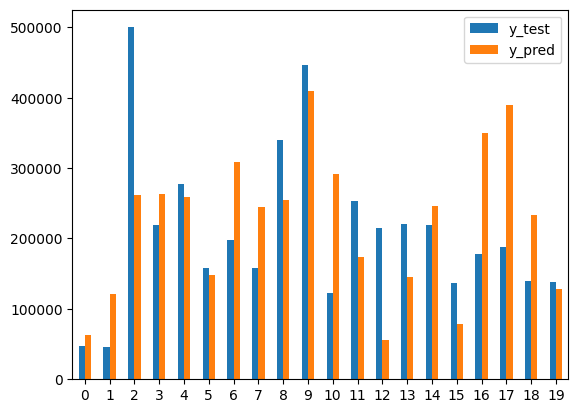

In [8]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(y_test, housing_predictions)  # check the error
show=20
df = pd.DataFrame({'y_test': y_test[:show].to_numpy(), 'y_pred': housing_predictions[:show]}, index=[x for x in range(show)])  # visualize some predictions
df.plot.bar(rot=0)
lin_rmse

# Are we satisfied?

This is better than nothing, but clearly not a great score: most districts’ `median_housing_values` range between 120K USD and  265K USD, so a typical prediction error of ~70K USD is not very satisfying. This is an example of a model underfitting the training
data.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

"A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree."

50155.05753085368


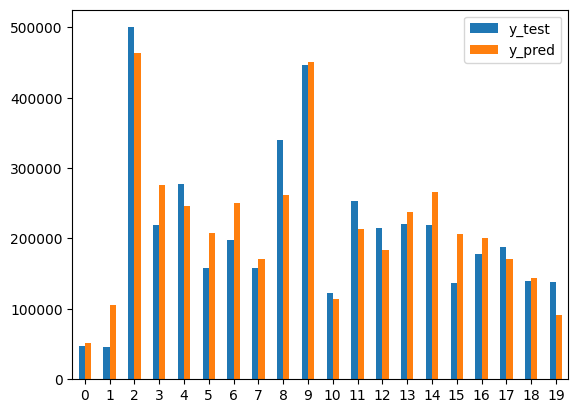

In [9]:
from sklearn.ensemble import RandomForestRegressor  # import the model

def run_forest(n_estimators, max_features, min_samples_split=5):
    forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42, bootstrap=True)  # initialize the model (i.e., the estimator)
    forest_reg.fit(X_train, y_train)  # train it
    housing_predictions = forest_reg.predict(X_test)  # predict the cost of houses in the test set
    forest_rmse = root_mean_squared_error(y_test, housing_predictions)  # check the error
    print(forest_rmse)
    df = pd.DataFrame({'y_test': y_test[:show].to_numpy(), 'y_pred': housing_predictions[:show]}, index=[x for x in range(show)])
    df.plot.bar(rot=0)
    return forest_reg

forest_reg = run_forest(100, 1.0)

# Hyperparameters

Look at parameters used by our current forest

In [10]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Random search

In [11]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'n_estimators': [2, 10, 25, 50, 100, 150],  # Number of trees in random forest
    'max_features': [1.0, 'sqrt'],  # Number of features to consider at every split
    'min_samples_split': [2, 5]
}

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_reg, param_distributions=random_grid, n_iter=5, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_features=1.0, min_samples_split=5, n_estimators=25; total time=   1.6s
[CV] END max_features=1.0, min_samples_split=5, n_estimators=25; total time=   1.5s
[CV] END max_features=1.0, min_samples_split=5, n_estimators=25; total time=   1.5s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_

{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt'}

49296.853444113134


RandomForestRegressor(max_features='sqrt', random_state=42)

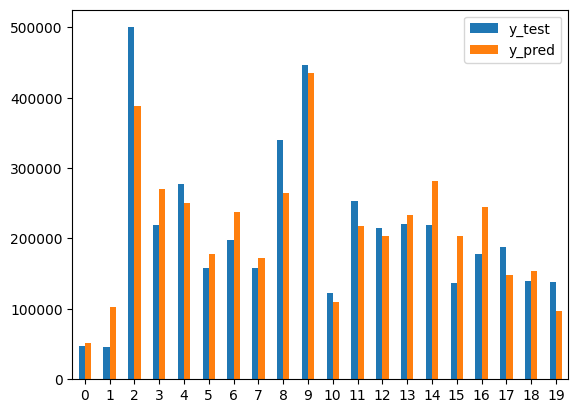

In [12]:
run_forest(n_estimators=100, min_samples_split=2, max_features='sqrt')

# Dimensionality reduction

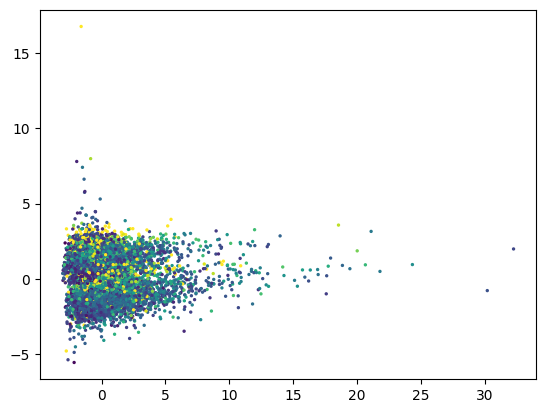

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(X_train.values)

plt.scatter(
    x=result[:, 0],
    y=result[:, 1],
    c=y_train,
    s=2,
    cmap='viridis'
)

In [14]:
pd.DataFrame(pca.components_, columns=X_train.columns, index=['PC1', 'PC2'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
PC1,0.067570,-0.064488,-0.218377,0.481213,0.491136,0.475472,0.491947,0.045903,-0.004028,0.007194,-0.011824,0.014685,0.001303,-0.000042,-0.013497,-0.002449
PC2,-0.593374,0.610175,-0.081621,0.108533,0.009148,-0.021333,0.004461,0.222566,0.008746,0.284716,-0.304254,-0.140430,0.082383,-0.000152,0.079831,-0.021631


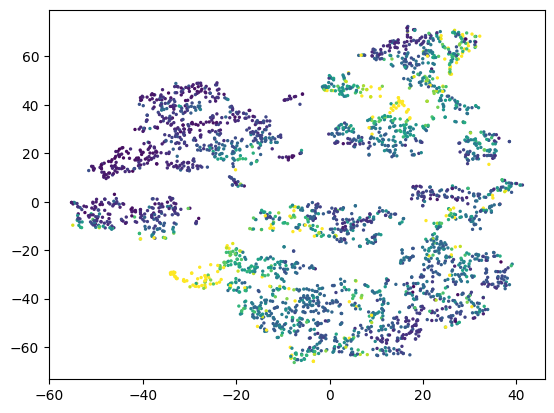

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
result = tsne.fit_transform(X_train.head(3000))

plt.scatter(
    x=result[:, 0],
    y=result[:, 1],
    c=y_train.head(3000),
    s=2,
    cmap='viridis'
)

## Classification

Can we turn this into a classification problem?

<Axes: >

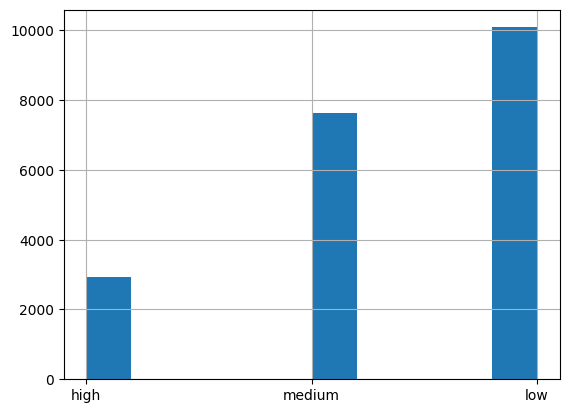

In [16]:
df = preprocess(False)  # clean the dataset withtout standardization
bins = ["low", "medium", "high"]  # the labels we are gonna use
# map bins of values into labels
df["median_house_value"] = pd.cut(df["median_house_value"], 3, labels=bins)
df["median_house_value"].hist()  # plot them


For the sake of performance, we are going to use a manually defined set of features

In [17]:
y = df["median_house_value"]  # labels
# consider only some features from the train dataset
X = df[["latitude", "longitude", "median_income", "population", "households", "total_bedrooms"]]
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Computing performance


![Picture2](https://user-images.githubusercontent.com/18005592/232803278-7a0e5182-4267-410a-a809-7edc54a47980.png)

![Picture3](https://user-images.githubusercontent.com/18005592/232803261-1cae7aac-e3fc-4467-bb45-65455d7a34a7.png)

- Precision: $\frac{tp}{tp + fp}$
- Recall: $\frac{tp}{tp + fn}$
- Accuracy: $\frac{tp + tn}{tp + tn + fp + fpn}$
- F1-score: $2 \cdot \frac{precision \cdot recall}{precision + recall}$

Summing up
- Accuracy is used when TP and TN are more important while F1-score is used when FN and FP are
- Accuracy can be used when the class distribution is similar, while F1-score is a better when there are imbalanced classes


In [18]:
from sklearn.metrics import accuracy_score
from sklearn import tree
# initialize the model
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=42)
clf = clf.fit(X_train, y_train)  # train it
# predict the cost of houses in the test set
housing_predictions = clf.predict(X_test)
# check the error
accuracy = accuracy_score(y_test, housing_predictions)
accuracy

0.768349970640047

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, housing_predictions, target_names=bins))

              precision    recall  f1-score   support

         low       0.67      0.70      0.68       958
      medium       0.84      0.84      0.84      3303
        high       0.71      0.70      0.70      2551

    accuracy                           0.77      6812
   macro avg       0.74      0.75      0.74      6812
weighted avg       0.77      0.77      0.77      6812



[Text(0.5, 0.9166666666666666, 'median_income <= 4.12\nentropy = 1.435\nsamples = 13828\nvalue = [1970.0, 6786.0, 5072.0]\nclass = medium'),
 Text(0.25, 0.75, 'median_income <= 2.662\nentropy = 1.099\nsamples = 8778\nvalue = [413, 5957, 2408]\nclass = medium'),
 Text(0.375, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'latitude <= 37.89\nentropy = 0.731\nsamples = 3835\nvalue = [81, 3211, 543]\nclass = medium'),
 Text(0.0625, 0.4166666666666667, 'longitude <= -122.305\nentropy = 0.837\nsamples = 2927\nvalue = [79, 2340, 508]\nclass = medium'),
 Text(0.03125, 0.25, 'latitude <= 37.755\nentropy = 1.263\nsamples = 57\nvalue = [13, 7, 37]\nclass = high'),
 Text(0.015625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.046875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09375, 0.25, 'longitude <= -117.125\nentropy = 0.796\nsamples = 2870\nvalue = [66, 2333, 471]\nclass = medium'),
 Text(0.078125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.109375, 0.08333333333333333

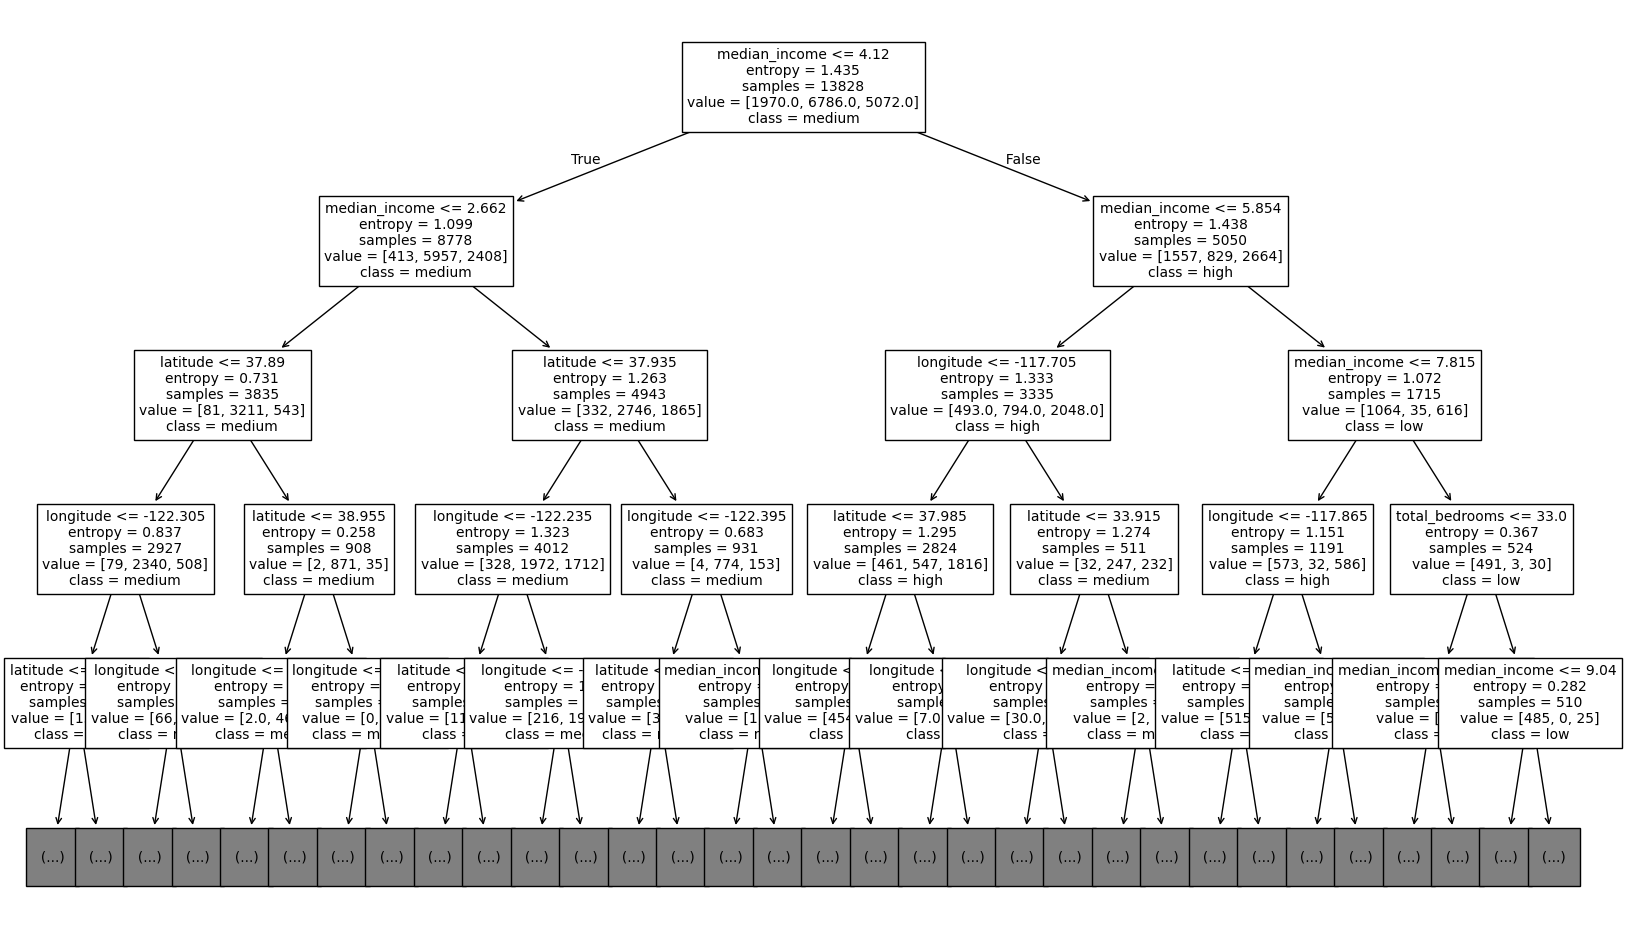

In [20]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=10, feature_names=X_train.columns, class_names=bins, max_depth=4)

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(criterion="entropy", random_state=42) # initialize the model
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.8247210804462712

In [22]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [23]:
random_grid = {'n_estimators': [50, 100, 150], # Number of trees in random forest
               'max_features': [1.0, 'sqrt'], # Number of features to consider at every split
               'min_samples_leaf': [1, 5],
               'max_depth': [2, 5]
              }

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_cls, param_distributions=random_grid, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.3s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.3s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_est

{'n_estimators': 100,
 'min_samples_leaf': 1,
 'max_features': 1.0,
 'max_depth': 5}

In [24]:
forest_cls = RandomForestClassifier(criterion="gini", random_state=42, n_estimators=50, max_features="sqrt", min_samples_leaf=1, max_depth=5)
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.7298884321785085

In [25]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## AutoML with FLAML

In [26]:
scale_mapper = {"low": 1, "medium": 2, "high": 3}
y_train = y_train.replace(scale_mapper)
y_test = y_test.replace(scale_mapper)
y_train

C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_24252\2541085399.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace(scale_mapper)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_24252\2541085399.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_train = y_train.replace(scale_mapper)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_24252\2541085399.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `r

5088     1
17096    3
5617     2
20060    1
895      2
        ..
11284    2
11964    1
5390     2
860      2
15795    2
Name: median_house_value, Length: 13828, dtype: category
Categories (3, int64): [1 < 2 < 3]

Check https://microsoft.github.io/FLAML/docs/reference/automl/automl#automl-objects

In [27]:
from flaml import AutoML

automl_settings = {
    "time_budget": 60,  # in seconds
    "metric": "accuracy",
    "task": "classification",
}

automl = AutoML()
automl.fit(X_train, y_train, **automl_settings)

[flaml.automl.logger: 10-09 10:05:28] {1728} INFO - task = classification
[flaml.automl.logger: 10-09 10:05:28] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 10-09 10:05:28] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 10-09 10:05:28] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 10-09 10:05:28] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-09 10:05:28] {2393} INFO - Estimated sufficient time budget=1777s. Estimated necessary time budget=41s.
[flaml.automl.logger: 10-09 10:05:28] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.3435,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 10-09 10:05:28] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-09 10:05:28] {2442} INFO -  at 0.4s,	estimator lgbm's best error=0.3435,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 10-09

In [28]:
automl.model.estimator

LGBMClassifier(colsample_bytree=np.float64(0.6782006405163307),
               learning_rate=np.float64(0.08222714104485478), max_bin=511,
               min_child_samples=3, n_estimators=1, n_jobs=-1, num_leaves=253,
               reg_alpha=np.float64(0.003934614746573571),
               reg_lambda=np.float64(0.003560646472734122), verbose=-1)

In [29]:
# Score the model
housing_predictions = automl.predict(X_test)
housing_predictions

array([1, 1, 3, ..., 1, 1, 2])

0.40710801370263433


<Axes: >

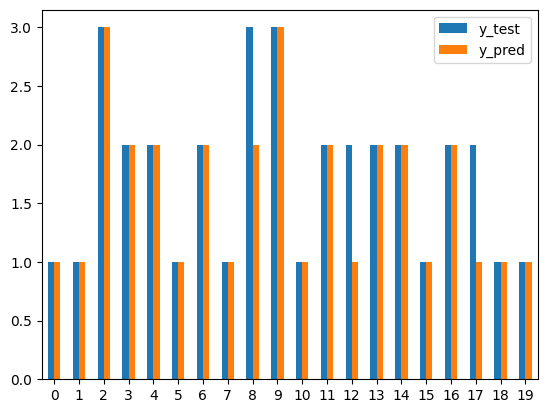

In [32]:
automl_rmse = root_mean_squared_error(y_test, housing_predictions)  # check the error
print(automl_rmse)
df = pd.DataFrame({'y_test': y_test[:20].to_numpy(), 'y_pred': housing_predictions[:20]}, index=[x for x in range(20)])
df.plot.bar(rot=0)

# Exercise

In [33]:
# Can you do better?